In [ ]:
# 思路：把数据分成两部分，一部分只有数字变量，一部分是text
# 分别进行embedding化成向量后在训练的途中结合在一起，最后求出回归的值

In [ ]:
# Training process

In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from verstack.stratified_continuous_split import scsplit # pip install verstack
from nltk.corpus import stopwords 

import torch
import torch.nn.functional as F



from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import gensim
from gensim.models.doc2vec import Doc2Vec
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the training data
train_data = pd.read_csv("data/train.csv")
train_data.head()

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049


In [3]:
train_data.shape

(353969, 12)

In [4]:
# replace the columns of ["mentions","urls","hashtags"] by the number of their elements
def count_item(str_):
    str_=str_[1:-1]
    if (len(str_)==0):
        return 0
    list_str_=str_.split(",")
    return len(list_str_)

In [5]:
def count_num(data,list_column):
    for name_column in list_column:
        data[name_column]=[count_item(content) for content in data[name_column]]

In [6]:
data_analyse=train_data.drop(["TweetID","timestamp","text"], axis=1)
count_num(data_analyse,["mentions","urls","hashtags"])

In [7]:
data_analyse.head()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags
0,3,0,3682,453535,3628,0,0,0,0
1,0,0,86,1016,284,0,0,0,0
2,3,1,1944,28234,1995,0,0,0,0
3,0,0,1,1072,0,0,1,0,0
4,0,0,13957,25311,10841,0,0,0,0


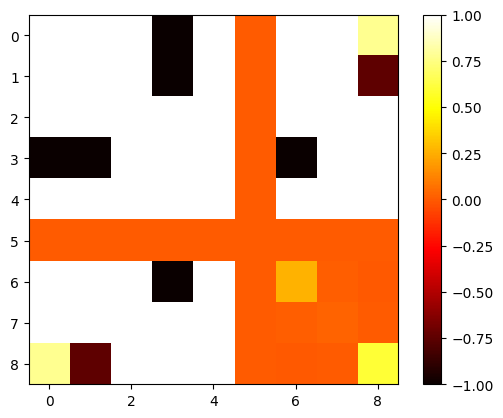

In [9]:
data_cov=np.cov(data_analyse.T)
plt.imshow(data_cov, cmap=plt.cm.hot, vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [10]:
pd.DataFrame(data_cov)

,0,1,2,3,4,5,6,7,8
0,5.855757e+04,1.709865e+05,3.702179e+06,-2.817059e+04,1.401132e+04,0.0,3.068365,4.110938,0.776434
1,1.709865e+05,7.259796e+05,1.298201e+07,-2.858000e+05,2.144170e+04,0.0,5.638866,11.519760,-0.747641
2,3.702179e+06,1.298201e+07,6.753319e+10,4.797285e+09,5.286065e+06,0.0,7585.033178,16478.893056,1077.745043
3,-2.817059e+04,-2.858000e+05,4.797285e+09,1.285625e+10,6.914994e+07,0.0,-3696.893972,1532.060995,2000.633368
4,1.401132e+04,2.144170e+04,5.286065e+06,6.914994e+07,6.264675e+06,0.0,23.748410,15.354028,100.913752
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000
6,3.068365e+00,5.638866e+00,7.585033e+03,-3.696894e+03,2.374841e+01,0.0,0.259797,0.010174,-0.003258
7,4.110938e+00,1.151976e+01,1.647889e+04,1.532061e+03,1.535403e+01,0.0,0.010174,0.029105,0.003022
8,7.764342e-01,-7.476406e-01,1.077745e+03,2.000633e+03,1.009138e+02,0.0,-0.003258,0.003022,0.595495


In [59]:
pca=PCA(n_components=2,copy=True)

In [60]:
pca.fit(data_analyse)

PCA(n_components=2)

In [65]:
data_pca=pca.fit_transform(data_analyse)
data_pca.shape

(353969, 2)

In [66]:
data_pca[:,0]

array([ 18700.15084755, -24136.83478264, -19924.51556502, ...,
       -22367.53339664, -24130.00371346, -24303.57400447])

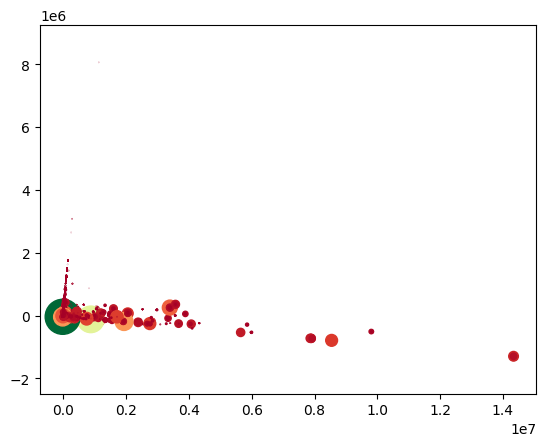

In [84]:
# cmap=plt.colormaps["tab20c"]
fig = plt.figure()
ax = plt.axes()
ax.scatter(data_pca[:,0],data_pca[:,1],s=np.array(data_analyse["retweets_count"].tolist())*0.01+0.01,c=data_analyse["retweets_count"].tolist(),cmap="RdYlGn")
ax.axis("equal")  
plt.show()

In [7]:
# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(["retweets_count","TweetID"], axis=1)
X_test = X_test.drop(["retweets_count","TweetID"], axis=1)

In [4]:
X_train.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
340724,macron réélu melanmachin jamais fort heureusement,0,4,84,6,[],[],0,[],1647292340000
92844,sondages candidats tour gauche important faire...,313,8408,32672,8622,[],['https://t.co/kraasmxhlz'],0,[],1647353797000
112020,bonsoir famille lâchez votez allez bordeauxxxx,0,559,10866,691,[],['https://t.co/ozjik9ybmx'],0,[],1647635808000
266279,pécresse vendu rachete double,3,443,8980,741,[],[],0,"['lefaceaface', 'lci', 'pecressenaufrage', 'al...",1646941168000
82695,fou hidalgo dernière sondages canard boiteux c...,50,22,3830,177,[],[],0,[],1647017617000


In [8]:
count_num(X_train,["mentions","urls","hashtags"])
count_num(X_test,["mentions","urls","hashtags"])

In [8]:
X_train.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
340724,macron réélu melanmachin jamais fort heureusement,0,4,84,6,0,0,0,0,1647292340000
92844,sondages candidats tour gauche important faire...,313,8408,32672,8622,0,1,0,0,1647353797000
112020,bonsoir famille lâchez votez allez bordeauxxxx,0,559,10866,691,0,1,0,0,1647635808000
266279,pécresse vendu rachete double,3,443,8980,741,0,0,0,5,1646941168000
82695,fou hidalgo dernière sondages canard boiteux c...,50,22,3830,177,0,0,0,0,1647017617000


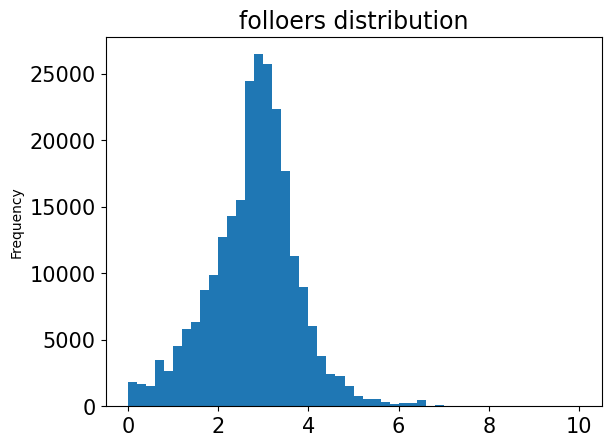

In [12]:
np.log10(X_train['followers_count']).plot.hist(bins=50,range=[0,10])
plt.tick_params(labelsize=15)
plt.title('folloers distribution', fontsize=17)
plt.show()

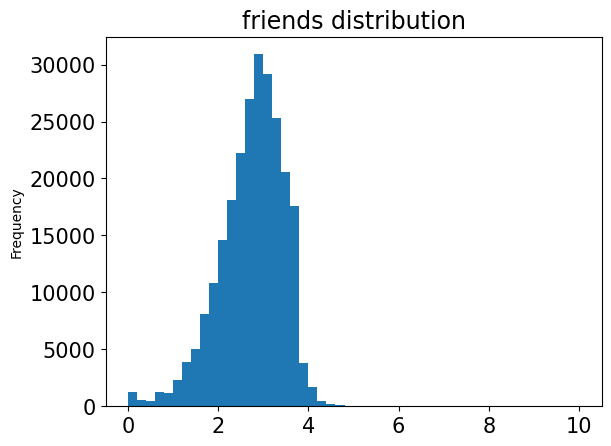

In [13]:
np.log10(X_train['friends_count']).plot.hist(bins=50,range=[0,10])
plt.tick_params(labelsize=15)
plt.title('friends distribution', fontsize=17)
plt.show()

In [9]:
# standardise the columns of numeric values
def standardise(data,list_column):
    for name_column in list_column:
        if data[name_column].std()!=0:
            data[name_column]=(data[name_column]-data[name_column].mean())/data[name_column].std()
        else:
            data[name_column]=(data[name_column]-data[name_column].mean())

In [10]:
standardise(X_train,["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"])
standardise(X_test,["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"])

In [16]:
X_test.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
189606,article constitution procédé nouvelle dissolut...,-0.055739,-0.065147,1.901790,-0.476549,0.0,0.925575,-0.175443,-0.384052,0.086927
213943,faire confiance tyrans pareil,-0.050964,-0.075350,-0.414226,0.691358,0.0,-1.034808,-0.175443,3.480158,0.056251
163776,tweet pue gauche pourtant jsuis,-0.055739,-0.078332,-0.422332,-0.512745,0.0,-1.034808,-0.175443,-0.384052,0.142391
49651,rt partie,-0.055739,-0.062549,5.617279,1.419288,0.0,-1.034808,-0.175443,-0.384052,0.140013
163469,rt essentiel question vote blanc consiste élec...,-0.055739,-0.071335,1.490695,0.393348,0.0,-1.034808,-0.175443,-0.384052,0.122947


In [ ]:
# split the table into 2 parts: one with the text and the other with the numbers

In [11]:
X_train_num=X_train[["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"]]

X_test_num=X_test[["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"]]

X_train_num.head()

,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
303242,-0.055617,-0.075053,-0.299582,0.158277,0.0,-1.037267,-0.175529,0.916075,-0.015577
44027,-0.055617,-0.077780,-0.392448,-0.545376,0.0,-1.037267,-0.175529,-0.384756,0.087356
152938,-0.055617,-0.078206,-0.415958,-0.552626,0.0,-1.037267,-0.175529,-0.384756,-0.012243
250138,-0.055617,-0.073838,0.108052,-0.209459,0.0,-1.037267,-0.175529,-0.384756,0.046891
330912,-0.055617,-0.074952,-0.406574,-0.160320,0.0,-1.037267,-0.175529,0.916075,0.011600


In [12]:
X_train_text=X_train["text"]
X_test_text=X_test["text"]
X_train_text.head()

303242    rt jamais oublier collabo parti communiste chi...
44027                                       haine président
152938    rt servi servilement idéologie europeiste audi...
250138    rt posez question lrem prochaine mise examen c...
330912    rt potentiel électoral samedi mars stabilise r...
Name: text, dtype: object

In [19]:
# these parts are used to train the embedding of the vocabulary, only needed to be run once

In [13]:
def get_text(file):
    data_text=pd.read_table(file)
    return data_text

In [14]:
path_text_dataset='French-Word-Embeddings/Data/data.txt'
text_dataset=get_text(path_text_dataset).values
text_dataset=[item[0][:-1] for item in text_dataset]
text_dataset[:5]

['aurant la thérapie , et au niveau sexuel ',
 'pas encore  ',
 'il veut mettre fin au mariage  ',
 'je suis une mauvaise artiste  ',
 "ce cours t'a pourtant fait du bien  "]

In [15]:
TaggedDocument=gensim.models.doc2vec.TaggedDocument
def X_text(sentences):
    X=[]
    for i,text in enumerate(sentences):
        words=text.split(" ")
        l=len(words)
        words=words[:-2]
        document=TaggedDocument(words,tags=[i])
        X.append(document)
    return X

In [16]:
X_documents=X_text(text_dataset)
X_documents[:5]

[TaggedDocument(words=['aurant', 'la', 'thérapie', ',', 'et', 'au', 'niveau'], tags=[0]),
 TaggedDocument(words=['pas', 'encore'], tags=[1]),
 TaggedDocument(words=['il', 'veut', 'mettre', 'fin', 'au', 'mariage'], tags=[2]),
 TaggedDocument(words=['je', 'suis', 'une', 'mauvaise', 'artiste'], tags=[3]),
 TaggedDocument(words=['ce', 'cours', "t'a", 'pourtant', 'fait', 'du', 'bien'], tags=[4])]

In [16]:
def train_text(text_train,size=100,epochs=10):
    model=Doc2Vec(text_train,min_count=1,window=3,vector_size=size,sample=1e-3,negative=5,epochs=epochs)
    model.train(text_train,total_examples=model.corpus_count,epochs=model.epochs)
    return model

In [18]:
model_text=train_text(X_documents)
if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')
model_text.save('WE_models/d2v_100D')

In [ ]:
# load the model

In [17]:
model_text=Doc2Vec.load('WE_models/d2v_100D')

In [18]:
def text2vec(text_train,alpha=0.05, min_alpha=0.025, epochs=10):
    list_text=[]
    for sentence in text_train:
        words=sentence.split(" ")
        vec=model_text.infer_vector(doc_words=words, alpha=alpha, min_alpha=min_alpha, epochs=epochs).tolist()
        list_text.append(vec)
    return np.array(list_text)

In [19]:
# tencor of the text part
X_train_text_vec=text2vec(X_train_text,alpha=0.05, min_alpha=0.025, epochs=10)
X_train_text_tensor=torch.Tensor(X_train_text_vec)
X_train_text_tensor

tensor([[ 0.1365, -0.2539, -0.1900,  ..., -0.2024, -0.3403, -0.2197],
        [-0.0332, -0.1846,  0.1024,  ...,  0.0202, -0.1659, -0.0284],
        [ 0.0717, -0.3217,  0.1707,  ..., -0.0607, -0.0546,  0.3065],
        ...,
        [ 0.1774, -0.3922, -0.0091,  ...,  0.0247, -0.1649, -0.0170],
        [ 0.8420, -0.3545, -0.1410,  ..., -0.0791,  0.2907,  0.4693],
        [ 0.1175, -0.5477, -0.1867,  ..., -0.4736, -0.2299,  0.0729]])

In [20]:
X_train_text_tensor[0]

tensor([ 0.1365, -0.2539, -0.1900, -0.0183, -0.1249, -0.2657, -0.2947,  0.1664,
         0.1706,  0.0109, -0.4954,  0.2999, -0.3470,  0.5038,  0.4481, -0.0209,
        -0.0613, -0.0904,  0.5193,  0.1538, -0.3541,  0.1184,  0.0974,  0.1239,
        -0.2694, -0.0721, -0.0353, -0.0986,  0.5917, -0.1812, -0.5996,  0.4210,
         0.5866, -0.4143,  0.4464,  0.1816, -0.3000,  0.0169, -0.2261,  0.5593,
         0.2890, -0.1981,  0.3676, -0.0157, -0.1671, -0.1252,  0.0462,  0.3381,
        -0.0652,  0.0042, -0.2098,  0.2528,  0.0336, -0.4749,  0.2263,  0.5638,
         0.1933, -0.0614, -0.0980,  0.0937,  0.1522,  0.1028,  0.0317, -0.2617,
         0.1405, -0.0461,  0.0602, -0.4215, -0.0168, -0.2810, -0.1537, -0.3595,
        -0.1636,  0.0984, -0.2649, -0.1527, -0.0956, -0.4666, -0.1462, -0.0801,
        -0.4064, -0.4506,  0.2985,  0.2979,  0.1930, -0.1089,  0.0767, -0.1421,
        -0.0998,  0.0534,  0.1239,  0.3349,  0.0301,  0.1258, -0.2659, -0.2306,
        -0.2205, -0.2024, -0.3403, -0.21

In [21]:
X_test_text_vec=text2vec(X_test_text,alpha=0.05, min_alpha=0.025, epochs=10)
X_test_text_tensor=torch.Tensor(X_test_text_vec)
X_test_text_tensor

tensor([[-0.0509, -0.1136,  0.1507,  ..., -0.1172,  0.2014,  0.0048],
        [ 0.5537, -0.1874,  0.6107,  ...,  0.5456,  0.4527,  0.1043],
        [ 0.3615,  0.1271,  0.2152,  ..., -0.1186,  0.1501, -0.0149],
        ...,
        [-0.0729, -0.1364,  0.0684,  ..., -0.2771, -0.2668,  0.0332],
        [-0.4250, -0.2997,  0.5512,  ...,  0.1201,  0.2872,  0.3321],
        [ 0.1256, -0.2388,  0.0581,  ...,  0.0571, -0.0966,  0.4031]])

In [136]:
# tensor of the numeric part
X_train_num_vec=X_train_num.values
X_train_num_tensor=torch.Tensor(X_train_num_vec)
X_test_num_vec=X_test_num.values
X_test_num_tensor=torch.Tensor(X_test_num_vec)

In [137]:
y_train_tensor=torch.Tensor(y_train.to_numpy())
y_train_tensor=y_train_tensor.reshape((-1,1))
y_test_tensor=torch.Tensor(y_test.to_numpy())
y_test_tensor=y_test_tensor.reshape((-1,1))

In [24]:
dataset_XY = torch.utils.data.TensorDataset(X_train_num_tensor.to(device),X_train_text_tensor.to(device), y_train_tensor.to(device))
testset_XY = torch.utils.data.TensorDataset(X_test_num_tensor.to(device), X_test_text_tensor.to(device), y_test_tensor.to(device))

In [ ]:
# ML methods

In [35]:
X_train_num_vec.shape

(247778, 9)

In [37]:
X_train_text_vec.shape

(247778, 100)

In [25]:
def MAE(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        sum+=abs(pred[i]-real[i])
    return sum/N

In [26]:
def ACC(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        if pred[i]==real[i]:
            sum+=1
    return sum/N

In [27]:
X_train_vec=np.hstack([X_train_text_vec,X_train_num_vec])
X_train_vec.shape

(247778, 109)

In [123]:
X_train_tensor=torch.Tensor(X_train_vec)

In [28]:
X_test_vec=np.hstack([X_test_text_vec,X_test_num_vec])
X_test_vec.shape

(106191, 109)

In [124]:
X_test_tensor=torch.Tensor(X_test_vec)

In [138]:
dataset_tot_XY = torch.utils.data.TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
testset_tot_XY = torch.utils.data.TensorDataset(X_test_tensor.to(device), y_test_tensor.to(device))

In [ ]:
dataset_num_XY = torch.utils.data.TensorDataset(X_train_num_tensor.to(device), y_train_tensor.to(device))
testset_num_XY = torch.utils.data.TensorDataset(X_test_num_tensor.to(device), y_test_tensor.to(device))

In [31]:
def model_result(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array([int(value) if value >= 0 else 0 for value in y_pred])
    loss=MAE(y_pred,y_test)
    acc=ACC(y_pred,y_test)
    return loss,acc

In [41]:
alpha_list=[0.1*i for i in range(30)]
loss_Lasso_tot=[]
acc_Lasso_tot=[]
for alpha in alpha_list:    
    print(alpha)
    model_Lasso=Lasso(alpha=alpha)
    loss_Lasso,acc_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_Lasso_tot.append(loss_Lasso[0])
    acc_Lasso_tot.append(acc_Lasso)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004


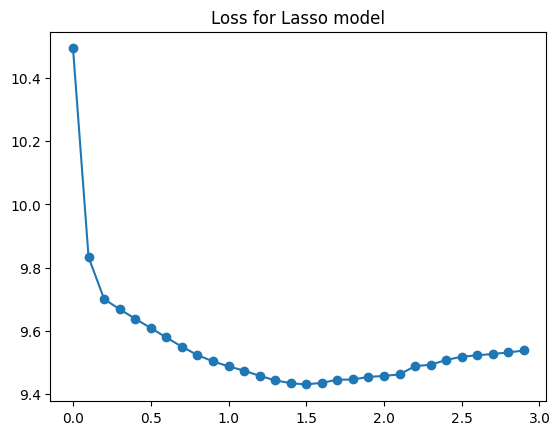

In [42]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_Lasso_tot)
ax.plot(alpha_list,loss_Lasso_tot) 
plt.title("Loss for Lasso model")
plt.show()

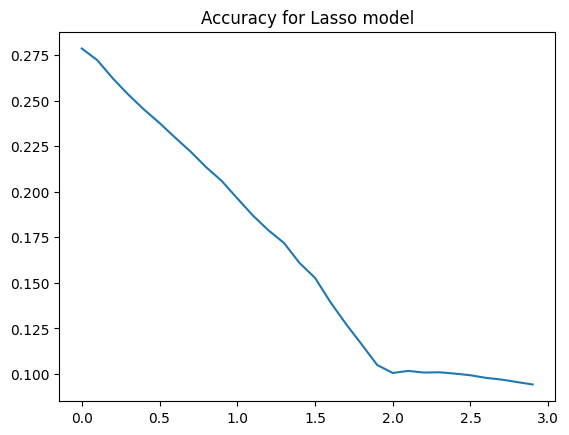

In [43]:
fig = plt.figure()
ax = plt.axes()
ax.plot(alpha_list,acc_Lasso_tot) 
plt.title("Accuracy for Lasso model")
plt.show()

In [44]:
model_Lasso=Lasso(alpha=0.1*np.argmin(np.array(loss_Lasso_tot)))

In [45]:
loss_Lasso,acc_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [46]:
loss_Lasso

array([9.43105348])

In [47]:
acc_Lasso

0.15275305816877136

In [166]:
loss_Lasso_num,acc_Lasso_num=model_result(model_Lasso,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)

In [167]:
loss_Lasso_num

array([11.01404074])

In [168]:
acc_Lasso_num

0.18074978105489165

In [52]:
alpha_list=[(i+1) for i in range(6,14)]
loss_Knn_tot=[]
acc_Knn_tot=[]
for alpha in alpha_list:    
    print(alpha)
    model_Knn=KNeighborsRegressor(n_neighbors=alpha)
    loss_Knn,acc_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_Knn_tot.append(loss_Knn[0])
    acc_Knn_tot.append(acc_Knn)

7
8
9
10
11
12
13
14


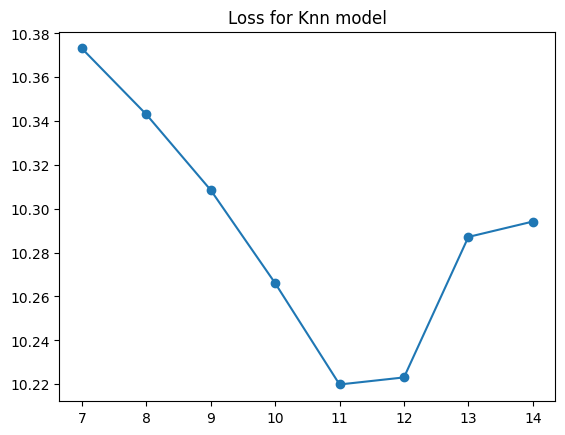

In [53]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_Knn_tot)
ax.plot(alpha_list,loss_Knn_tot) 
plt.title("Loss for Knn model")
plt.show()

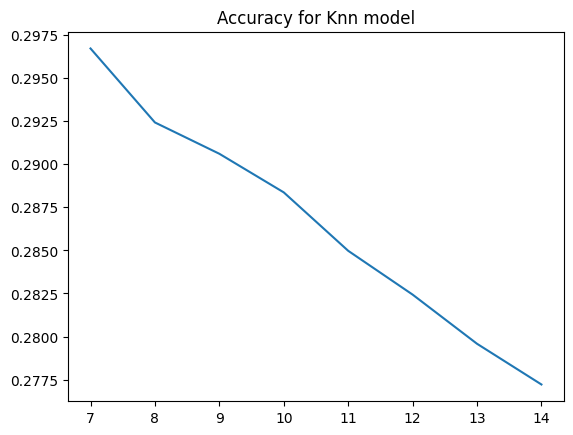

In [54]:
fig = plt.figure()
ax = plt.axes()
ax.plot(alpha_list,acc_Knn_tot) 
plt.title("Accuracy for Knn model")
plt.show()

In [62]:
model_Knn=KNeighborsRegressor(n_neighbors=11)

In [63]:
loss_Knn,acc_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [64]:
loss_Knn

array([10.21987739])

In [65]:
acc_Knn

0.28497706961983593

In [49]:
loss_Knn_num,acc_Knn_num=model_result(model_Knn,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)

In [50]:
loss_Knn_num

array([7.30500702])

In [51]:
acc_Knn_num

0.3868877776836078

In [ ]:
# 5 7.41351904 0.12514243203284647 7.36766769 0.12604646344793816

In [56]:
alpha_list=[i for i in range(10,20)]
loss_RF_tot=[]
acc_RF_tot=[]
for alpha in alpha_list:    
    print(alpha)
    model_RF=RandomForestRegressor(max_depth=alpha)
    loss_RF,acc_RF=model_result(model_RF,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_RF_tot.append(loss_RF[0])
    acc_RF_tot.append(acc_RF)

10
11
12
13
14
15
16
17
18
19


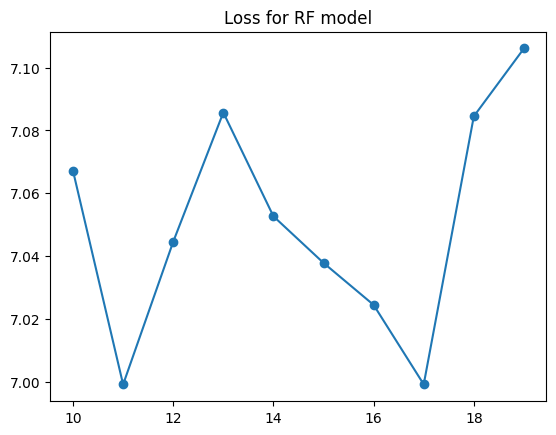

In [57]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_RF_tot)
ax.plot(alpha_list,loss_RF_tot) 
plt.title("Loss for RF model")
plt.show()

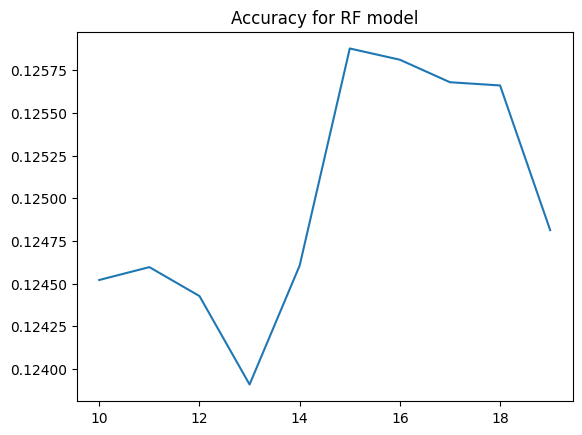

In [58]:
fig = plt.figure()
ax = plt.axes()
ax.plot(alpha_list,acc_RF_tot) 
plt.title("Accuracy for RF model")
plt.show()

In [95]:
model_RF=RandomForestRegressor(max_depth=17)

In [96]:
loss_RF,acc_RF=model_result(model_RF,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [97]:
loss_RF

array([7.07086288])

In [98]:
acc_RF

0.12563211571602112

In [99]:
loss_RF_num,acc_RF_num=model_result(model_RF,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)

In [100]:
loss_RF_num

array([7.0317541])

In [101]:
acc_RF_num

0.12377696791630176

In [55]:
model_SVR=SVR(kernel="rbf",C=1.0, epsilon=0.2)

In [ ]:
loss_SVR,acc_SVR=model_result(model_SVR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [ ]:
loss_SVR

In [ ]:
acc_SVR

In [ ]:
loss_SVR_num,acc_SVR_num=model_result(model_SVR,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)

In [ ]:
loss_SVR_num

In [ ]:
acc_SVR_num

In [184]:
model_LR=LinearRegression()

In [36]:
loss_LR,acc_LR=model_result(model_LR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [37]:
loss_LR

array([11.67475586])

In [38]:
acc_LR

0.22753340678588582

In [185]:
loss_LR_num,acc_LR_num=model_result(model_LR,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)

In [186]:
loss_LR_num

array([11.04352535])

In [187]:
acc_LR_num

0.1861833865393489

In [59]:
alpha_list=[1.0+0.1*i for i in range(5,14)]
loss_LogR_tot=[]
acc_LogR_tot=[]
for alpha in alpha_list:    
    print(alpha)
    model_LogR=LogisticRegression(C=alpha)
    loss_LogR,acc_LogR=model_result(model_LogR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_LogR_tot.append(loss_LogR[0])
    acc_LogR_tot.append(acc_LogR)

1.5
1.6
1.7000000000000002
1.8
1.9
2.0
2.1
2.2
2.3


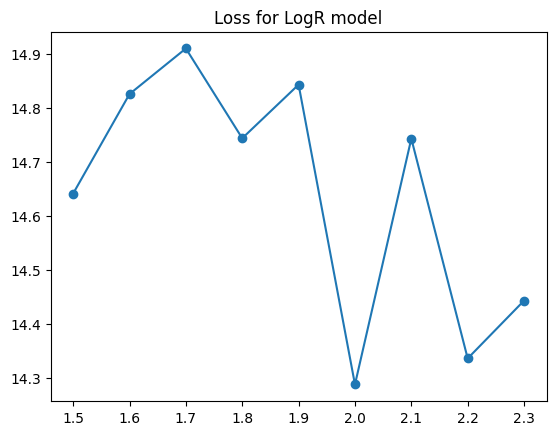

In [60]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_LogR_tot)
ax.plot(alpha_list,loss_LogR_tot) 
plt.title("Loss for LogR model")
plt.show()

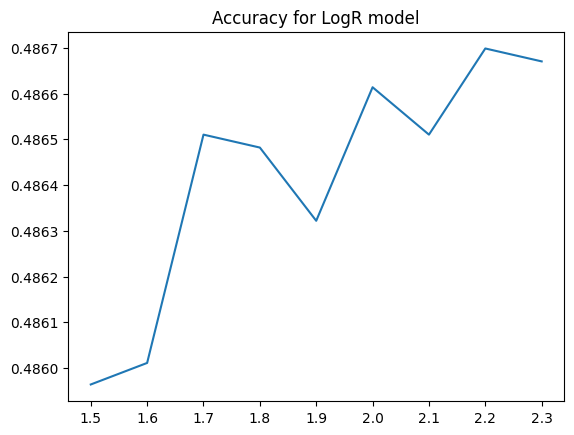

In [61]:
fig = plt.figure()
ax = plt.axes()
ax.plot(alpha_list,acc_LogR_tot) 
plt.title("Accuracy for LogR model")
plt.show()

In [91]:
model_LogR=LogisticRegression(C=2.0)

In [92]:
loss_LogR,acc_LogR=model_result(model_LogR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [93]:
loss_LogR

array([14.28829185])

In [94]:
acc_LogR

0.48661374316090816

In [189]:
loss_LogR_num,acc_LogR_num=model_result(model_LogR,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)

In [190]:
loss_LogR_num

array([16.27716096])

In [191]:
acc_LogR_num

0.4866796621182586

In [ ]:
# build the net 这里开始要改的

In [108]:
class RegressionNet(torch.nn.Module):
    def __init__(self, width_num, width_text, hidden,final):
        super(RegressionNet, self).__init__()
        self.layer_num_1 = torch.nn.Linear(width_num, hidden)
        self.layer_num_2 = torch.nn.Linear(hidden,final)
        self.layer_text_1 = torch.nn.Linear(width_text, hidden)
        self.layer_text_2 = torch.nn.Linear(hidden,final)
        self.predict=torch.nn.Linear(2*final, 1)
        self.dropout=torch.nn.Dropout(p=0.5)
    def forward(self, x_num,x_text):
        # x_num=x_num.flatten()
        
        
        x_num=self.layer_num_1(x_num)
        x_num=self.dropout(x_num)
        x_num = F.relu(x_num)
        x_num=self.layer_num_2(x_num)
        x_num=F.relu(x_num)
        
        # x_text=x_text.flatten()
        x_text=self.layer_text_1(x_text)
        x_text = self.dropout(x_text)
        x_text = F.relu(x_text)
        x_text=self.layer_text_2(x_text)
        x_text = F.relu(x_text)
        
        x_tot=torch.concat([x_num,x_text],dim=1)  
        x_tot=self.predict(x_tot)
        # x_tot=x_tot.int()
        for item in x_tot:
            item=0.0 if item<0 else item
        return x_tot

In [130]:
class RegressionNet_lstm(torch.nn.Module):
    def __init__(self, embedding_length,hidden_size, num_layers):
        super(RegressionNet_lstm, self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=torch.nn.LSTM(embedding_length,hidden_size,num_layers,batch_first=True)
        self.predict=torch.nn.Linear(hidden_size, 1)
        self.dropout=torch.nn.Dropout(p=0.5)
    def forward(self, x):
        # x_num=x_num.flatten()
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        
        out,_=self.lstm(x,(h0,c0))
        
        out=self.predict(out[:,-1,:])
        # x_tot=x_tot.int()
        x_tot=F.relu(out)
        return x_tot

In [131]:
batch_size=16

In [132]:
RNet=RegressionNet(X_train_num_tensor.shape[1],X_train_text_tensor.shape[1],20,5).to(device)

In [133]:
RNet_lstm=RegressionNet_lstm(X_train_tensor.shape[1],128,2).to(device)

In [111]:
def trainer(data_train,model,loss_fn,epoch=100,batch_size=16,rate=1e-3):
    optimiser=torch.optim.Adam(model.parameters(),lr=rate)
    loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)
    for i in range(epoch):
        if i%20==0:
            print("epoch "+str(i))
        for step,(batch_x_num,batch_x_text,batch_y) in enumerate(loader_train):    
            #print(batch_x.float())
            batch_x_num=batch_x_num.to(device)
            batch_x_text=batch_x_text.to(device)
            batch_y=batch_y.to(device)
            pred=model(batch_x_num,batch_x_text)
            #class_pred = torch.argmax(pred,dim = -1)
            loss=loss_fn(pred,batch_y)  
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if (step%10000==0) and step>0:
                print("now training step "+str(step))
                print(loss)

In [112]:
trainer(dataset_XY,RNet,torch.nn.CrossEntropyLoss(),epoch=100,batch_size=batch_size,rate=1e-3)

epoch 0
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-0., grad_fn=<DivBackward1>)
now training step 10000
tensor(-

In [147]:
def trainer_lstm(data_train,model,loss_fn,epoch=100,batch_size=16,rate=1e-3):
    optimiser=torch.optim.Adam(model.parameters(),lr=rate)
    loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)
    for i in range(epoch):
        if i%20==0:
            print("epoch "+str(i))
        for step,(batch_x,batch_y) in enumerate(loader_train):    
            #print(batch_x.float())
            batch_x=batch_x.reshape((-1,batch_x.shape[0],batch_x.shape[1]))
            batch_x=batch_x.to(device)
            batch_y=batch_y.to(device)
            pred=model(batch_x)
            #class_pred = torch.argmax(pred,dim = -1)
            loss=loss_fn(pred,batch_y)  
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if (step%1000==0) and step>0:
                print("now training step "+str(step))
                print(loss)

In [ ]:
trainer_lstm(dataset_tot_XY,RNet_lstm,MAE,epoch=100,batch_size=batch_size,rate=1e-3)

epoch 0
now training step 1000
tensor([0.], grad_fn=<DivBackward0>)
now training step 2000
tensor([0.], grad_fn=<DivBackward0>)
now training step 3000
tensor([0.], grad_fn=<DivBackward0>)
now training step 4000
tensor([0.], grad_fn=<DivBackward0>)
now training step 5000
tensor([4.], grad_fn=<DivBackward0>)
now training step 6000
tensor([3.], grad_fn=<DivBackward0>)
now training step 7000
tensor([0.], grad_fn=<DivBackward0>)
now training step 8000
tensor([2.], grad_fn=<DivBackward0>)
now training step 9000
tensor([3.], grad_fn=<DivBackward0>)
now training step 10000
tensor([2.], grad_fn=<DivBackward0>)
now training step 11000
tensor([1.], grad_fn=<DivBackward0>)
now training step 12000
tensor([0.], grad_fn=<DivBackward0>)
now training step 13000
tensor([8.], grad_fn=<DivBackward0>)
now training step 14000
tensor([0.], grad_fn=<DivBackward0>)
now training step 15000
tensor([1.], grad_fn=<DivBackward0>)
now training step 1000
tensor([5.], grad_fn=<DivBackward0>)
now training step 2000
ten

now training step 2000
tensor([0.], grad_fn=<DivBackward0>)
now training step 3000
tensor([1.], grad_fn=<DivBackward0>)
now training step 4000
tensor([0.], grad_fn=<DivBackward0>)
now training step 5000
tensor([0.], grad_fn=<DivBackward0>)
now training step 6000
tensor([2.], grad_fn=<DivBackward0>)
now training step 7000
tensor([0.], grad_fn=<DivBackward0>)
now training step 8000
tensor([0.], grad_fn=<DivBackward0>)
now training step 9000
tensor([2.], grad_fn=<DivBackward0>)
now training step 10000
tensor([0.], grad_fn=<DivBackward0>)
now training step 11000
tensor([0.], grad_fn=<DivBackward0>)
now training step 12000
tensor([3.], grad_fn=<DivBackward0>)
now training step 13000
tensor([5.], grad_fn=<DivBackward0>)
now training step 14000
tensor([1.], grad_fn=<DivBackward0>)
now training step 15000
tensor([1.], grad_fn=<DivBackward0>)
now training step 1000
tensor([1.], grad_fn=<DivBackward0>)
now training step 2000
tensor([21.], grad_fn=<DivBackward0>)
now training step 3000
tensor([1.

In [ ]:
trainer_lstm(dataset_num_XY,RNet_lstm,MAE,epoch=100,batch_size=batch_size,rate=1e-3)

In [113]:
def success_rate(model,loss_fn,batch_size,test_data):
    loader_test=torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True)
    loss_record=[]
    acc_record=[]
    total=0
    total_loss=0
    for step,(batch_x_num,batch_x_text,batch_y) in enumerate(loader_test):    
            #print(batch_x.float())
        pred=model(batch_x_num,batch_x_text)
        batch_x_num=batch_x_num.to(device)
        batch_x_text=batch_x_text.to(device)
        batch_y=batch_y.to(device)
            #class_pred = torch.argmax(pred,dim = -1)
        loss=loss_fn(pred,batch_y)  
        total_loss+=loss
        for i in range(len(pred)):
            if int(pred[i])==int(batch_y[i]):
                total+=1
        # 应该要把预测结果都变成int的，但这样可能产生预测结果全是0，求不了梯度不能反向传播了，要想个办法
        if step%1000==0:
            loss_record.append(total_loss)
            acc_record.append(total/((step+1)*batch_size))
    return total/len(test_data),total_loss,loss_record,acc_record

In [115]:
# 屎一样的准确率和误差
accuracy,MAE_loss,loss_record,acc_record=success_rate(RNet,MAE,batch_size,testset_XY)
print(accuracy)
print(MAE_loss)

0.4885913118814212
tensor([104635.], grad_fn=<AddBackward0>)


In [ ]:
def success_rate_lstm(model,loss_fn,batch_size,test_data):
    loader_test=torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True)
    loss_record=[]
    acc_record=[]
    total=0
    total_loss=0
    with torch.no_grad():
        for step,(batch_x,batch_y) in enumerate(loader_test):    
            #print(batch_x.float())
            batch_x=batch_x.reshape((-1,batch_size,batch_x.shape[1]))
            batch_x=batch_x.to(device)
            batch_y=batch_y.to(device)
            pred=model(batch_x)
            #class_pred = torch.argmax(pred,dim = -1)
            loss=loss_fn(pred,batch_y)  
            total_loss+=loss
            for i in range(len(pred)):
                if int(pred[i])==int(batch_y[i]):
                    total+=1
        # 应该要把预测结果都变成int的，但这样可能产生预测结果全是0，求不了梯度不能反向传播了，要想个办法
            if step%1000==0:
                loss_record.append(total_loss)
                acc_record.append(total/((step+1)*batch_size))
    return total/len(test_data),total_loss,loss_record,acc_record

In [ ]:
accuracy_lstm,MAE_loss_lstm,loss_record_lstm,acc_record_lstm=success_rate(RNet,MAE,batch_size,testset_tot_XY)

In [ ]:
MAE_loss_lstm

In [ ]:
accuracy_lstm,MAE_loss_lstm,loss_record_lstm,acc_record_lstm=success_rate(RNet,MAE,batch_size,testset_num_XY)

In [ ]:
MAE_loss_lstm

In [ ]:
# start evaluation

In [83]:
X_eval = pd.read_csv("data/evaluation.csv")
X_eval.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,descendue pourcentage vote,0,85,4442,327,[],[],0,"['presidentielle2022', 'hidalgo']",1647607994000,1184643
1,photo demande arbre généalogique,0,427,33282,443,[],[],0,[],1647601275000,1199190
2,dossiers promis poste gars vraiment fiable,6,1127,13111,1596,[],[],0,['macron'],1646900684000,917372
3,lol cas faut second tour macron sortir définit...,2,1699,25760,2036,[],['https://t.co/7ox54d8dlm'],0,[],1647161294000,731754
4,zemmour putain discours propagandiste littéral...,0,249,20718,369,[],"['https://t.co/tsw9cg6v9j', 'https://t.co/t0j9...",0,[],1647724874000,1400049


In [84]:
count_num(X_eval,["mentions","urls","hashtags"])
standardise(X_eval,["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"])

In [85]:
X_eval_num=X_eval[["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"]]
X_eval_text=X_eval["text"]

In [86]:
X_eval_text_vec=text2vec(X_eval_text,alpha=0.05, min_alpha=0.025, epochs=10)
X_eval_text_tensor=torch.Tensor(X_eval_text_vec)
X_eval_text_tensor

tensor([[-0.0876, -0.0849,  0.0715,  ..., -0.1274,  0.0259,  0.2036],
        [-0.0584, -0.2370,  0.0921,  ..., -0.1721, -0.1280, -0.0466],
        [-0.1301, -0.2114,  0.4126,  ..., -0.3209, -0.2384,  0.0885],
        ...,
        [ 0.0149, -0.2369,  0.5605,  ..., -0.2344, -0.2613,  0.3333],
        [ 0.4778,  0.2952,  0.1626,  ...,  0.4370, -0.0958,  0.7919],
        [-0.2888, -0.1849, -0.0242,  ...,  0.0029, -0.3252,  0.2898]])

In [87]:
X_eval_num_vec=X_eval_num.values
X_eval_num_tensor=torch.Tensor(X_eval_num_vec)

In [88]:
X_eval_vec=np.hstack([X_eval_text_vec,X_eval_num_vec])
X_eval_vec.shape

(117990, 109)

In [104]:
def evaluate_modle(model,filename):
    # y_val = model.predict(X_eval_num_vec)
    y_val = model.predict(X_eval_vec)
    y_val = np.array([int(value) if value >= 0 else 0 for value in y_val])
    y_val=y_val.reshape((-1,1))
    with open(filename, 'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "retweets_count"])
        for index, prediction in enumerate(y_val):
            writer.writerow([str(X_eval['TweetID'].iloc[index]) , str(int(prediction))])

In [105]:
evaluate_modle(model_RF,"RF_predictions.txt")

In [54]:
evaluate_modle(model_Knn,"Knn_predictions.txt")

In [118]:
dataset_eval = torch.utils.data.TensorDataset(X_eval_num_tensor.to(device),X_eval_text_tensor.to(device))

In [119]:
def evaluate(model,batch_size,test_eval):
    res=[]
    loader_eval=torch.utils.data.DataLoader(dataset=test_eval,batch_size=batch_size,shuffle=True)
    for step,(batch_x_num,batch_x_text) in enumerate(loader_eval):   
        batch_x_num=batch_x_num.to(device)
        batch_x_text=batch_x_text.to(device)
            #print(batch_x.float())
        pred=model(batch_x_num,batch_x_text)
            #class_pred = torch.argmax(pred,dim = -1)
        # print(pred)
        for i in range(len(pred)):
            pd=int(pred[i]) if pred[i]>0 else 0
            res.append(pd)
        if (step%10==0):
                print("now training step "+str(step))
    return res

In [120]:
evaluations=evaluate(RNet,batch_size,dataset_eval)

now training step 0
now training step 10
now training step 20
now training step 30
now training step 40
now training step 50
now training step 60
now training step 70
now training step 80
now training step 90
now training step 100
now training step 110
now training step 120
now training step 130
now training step 140
now training step 150
now training step 160
now training step 170
now training step 180
now training step 190
now training step 200
now training step 210
now training step 220
now training step 230
now training step 240
now training step 250
now training step 260
now training step 270
now training step 280
now training step 290
now training step 300
now training step 310
now training step 320
now training step 330
now training step 340
now training step 350
now training step 360
now training step 370
now training step 380
now training step 390
now training step 400
now training step 410
now training step 420
now training step 430
now training step 440
now training step 450

now training step 3820
now training step 3830
now training step 3840
now training step 3850
now training step 3860
now training step 3870
now training step 3880
now training step 3890
now training step 3900
now training step 3910
now training step 3920
now training step 3930
now training step 3940
now training step 3950
now training step 3960
now training step 3970
now training step 3980
now training step 3990
now training step 4000
now training step 4010
now training step 4020
now training step 4030
now training step 4040
now training step 4050
now training step 4060
now training step 4070
now training step 4080
now training step 4090
now training step 4100
now training step 4110
now training step 4120
now training step 4130
now training step 4140
now training step 4150
now training step 4160
now training step 4170
now training step 4180
now training step 4190
now training step 4200
now training step 4210
now training step 4220
now training step 4230
now training step 4240
now trainin

In [121]:
evaluations[:5]

[0, 0, 0, 0, 0]

In [122]:
with open("my_predictions.txt", 'w',newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(evaluations):
        writer.writerow([str(X_eval['TweetID'].iloc[index]) , str(int(prediction))])